Phase 2 Extension: Generative Simulations in 80-20 vs 70-30 Bandits task

This notebook extends the paper's denerative simulations by examining how models behave in a noisier environment (70-30) compared to the original 80-20 condition.

Models:
RFLR - generative, mouse-fit parameters
HMM Thompson Sampling - true task parameters
Sticky / Cost-Gated HMM

Metrics:
Reward per session
Reward per switch

Hypothesis:
Standard HMM will over-swicth in 70-30, while RFLR and Sticky HMM will maintain higher reward per switch. 

In [126]:
# Imports and paths
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

BEHAV_DIR = os.path.join(PROJECT_ROOT, "reproduction", "2ABT_behaviour_models")
if BEHAV_DIR not in sys.path:
    sys.path.insert(0, BEHAV_DIR)

import model_simulations as sim
import model_fitting as fit

OUTDIR = os.path.join(PROJECT_ROOT, "Extensions", "phase2_generative")
os.makedirs(OUTDIR, exist_ok=True)

np.random.seed(0)

In [127]:
# Load mouse data
df = pd.read_csv(os.path.join(BEHAV_DIR, "bandit_data.csv"))

df80 = df[df["Condition"] == "80-20"].copy()
df80 = df80.sort_values(["Session", "Trial"])

mouse_sessions_80 = []
for _, g in df80.groupby("Session"):
    choices = g["Decision"].astype(int).to_numpy()
    rewards = g["Reward"].astype(int).to_numpy()
    mouse_sessions_80.append((choices, rewards))

len(mouse_sessions_80)

159

In [128]:
# Fit RFLR on Mouse 80-20
rflr_params, nll = fit.fit_with_sgd(
    fit.log_probability_rflr,
    mouse_sessions_80,
    num_steps=4000,
    step_size=1e-2,
    init_parameters=(0.0, 1.0, 2.0),
)

alpha, beta, tau = map(float, rflr_params)
(alpha, beta, tau)

iteration  0 neg ll:  0.25747707
iteration  1000 neg ll:  0.18779886
iteration  2000 neg ll:  0.18509173
iteration  3000 neg ll:  0.1840569


(0.7112466096878052, 1.6068638563156128, 1.982416033744812)

In [129]:
# Generate Shared Environments
Q = 0.98
N_TRIALS = 30000

_, _, states_80 = sim.rflr_simulation(
    (alpha, beta, tau), task_params=(0.8, 1 - Q), nTrials=N_TRIALS
)

_, _, states_70 = sim.rflr_simulation(
    (alpha, beta, tau), task_params=(0.7, 1 - Q), nTrials=N_TRIALS
)

len(states_80), len(states_70)

(39, 39)

In [130]:
# Simulate RFLR Generatively


def run_rflr(states, p):
    _, sessions, _ = sim.rflr_simulation(
        (alpha, beta, tau), task_params=(p, 1 - Q), nTrials=len(states) * 750
    )
    return sessions


rflr_80 = run_rflr(states_80, 0.8)
rflr_70 = run_rflr(states_70, 0.7)

In [131]:
# Simulate HMM Thompson Sampling (True Task)


def run_hmm(states, p):
    mouse = sim.BayesianMouse({"p_switch": 1 - Q, "p_reward": p})
    return sim.simulate_experiment(
        params={"p_reward": p},
        mouse=mouse,
        states=states,
        policy="thompson",
        sticky=False,
    )


hmm_80 = run_hmm(states_80, 0.8)
hmm_70 = run_hmm(states_70, 0.7)

In [132]:
# Simulate Sticky / Cost-Gated HMM
import importlib
import model_simulations as sim

importlib.reload(sim)

sticky_80 = sim.simulate_experiment(
    params={"p_reward": 0.8},
    mouse=sim.BayesianMouse(
        {
            "p_switch": 1 - Q,
            "p_reward": 0.8,
            "alpha": alpha_hat,
            "beta": beta_hat,
            "tau": tau_hat,
        }
    ),
    states=states_80,
    policy="thompson",
    sticky=True,
)
sticky_70 = sim.simulate_experiment(
    params={"p_reward": 0.7},
    mouse=sim.BayesianMouse(
        {
            "p_switch": 1 - Q,
            "p_reward": 0.7,
            "alpha": alpha_hat,
            "beta": beta_hat,
            "tau": tau_hat,
        }
    ),
    states=states_70,
    policy="thompson",
    sticky=True,
)

In [133]:
# Metric Extraction


def metrics(sessions):
    rows = []
    for c, r, *_ in sessions:
        switches = np.sum(c[1:] != c[:-1])
        rows.append(
            {
                "reward_per_session": r.mean(),
                "reward_per_switch": r.sum() / max(1, switches),
                "switches": switches,
            }
        )
    return pd.DataFrame(rows)


summary = pd.concat(
    [
        metrics(rflr_80).assign(model="RFLR", cond="80-20"),
        metrics(rflr_70).assign(model="RFLR", cond="70-30"),
        metrics(hmm_80).assign(model="HMM", cond="80-20"),
        metrics(hmm_70).assign(model="HMM", cond="70-30"),
        metrics(sticky_80).assign(model="Sticky HMM", cond="80-20"),
        metrics(sticky_70).assign(model="Sticky HMM", cond="70-30"),
    ]
)

In [134]:
# Summary Table
summary.groupby(["model", "cond"]).agg(
    reward_per_session=("reward_per_session", "mean"),
    reward_per_switch=("reward_per_switch", "mean"),
    switches=("switches", "mean"),
)
summary.to_csv(os.path.join(OUTDIR, "summary_metrics_by_session.csv"), index=False)

In [135]:
from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations


def fdr_bh(pvals):
    pvals = np.asarray(pvals, dtype=float)
    n = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    adj = ranked * n / (np.arange(1, n + 1))
    adj = np.minimum.accumulate(adj[::-1])[::-1]
    adj = np.clip(adj, 0, 1)
    out = np.empty_like(adj)
    out[order] = adj
    return out


# 1) Omnibus test per condition (nonparametric, 3 groups)
metrics = ["reward_per_session", "reward_per_switch", "switches"]
conditions = ["70-30", "80-20"]
models = ["HMM", "RFLR", "Sticky HMM"]

omnibus_rows = []
for cond in conditions:
    d = summary[summary["cond"] == cond]
    for met in metrics:
        groups = [d.loc[d["model"] == m, met].dropna().values for m in models]
        H, p = kruskal(*groups)
        omnibus_rows.append({"cond": cond, "metric": met, "H": H, "p": p})

omnibus = pd.DataFrame(omnibus_rows)
omnibus["p_fdr"] = fdr_bh(omnibus["p"].values)
omnibus

omnibus.to_csv(os.path.join(OUTDIR, "stats_omnibus.csv"), index=False)

# 2) Pairwise post-hoc (Mann-Whitney U), FDR-corrected
pair_rows = []
for cond in conditions:
    d = summary[summary["cond"] == cond]
    for met in metrics:
        for m1, m2 in combinations(models, 2):
            x = d.loc[d["model"] == m1, met].dropna().values
            y = d.loc[d["model"] == m2, met].dropna().values
            U, p = mannwhitneyu(x, y, alternative="two-sided")
            pair_rows.append(
                {
                    "cond": cond,
                    "metric": met,
                    "m1": m1,
                    "m2": m2,
                    "U": U,
                    "p": p,
                    "med_m1": pd.Series(x).median(),
                    "med_m2": pd.Series(y).median(),
                }
            )

pairwise = pd.DataFrame(pair_rows)
pairwise["p_fdr"] = fdr_bh(pairwise["p"].values)
pairwise = pairwise.sort_values(["metric", "cond", "p_fdr"])
pairwise

pairwise.to_csv(os.path.join(OUTDIR, "stats_pairwise.csv"), index=False)

In [136]:
model_order = ["HMM", "Sticky HMM", "RFLR"]
model_colors = {
    "HMM": "#1f77b4",  # blue
    "RFLR": "#ff7f0e",  # orange
    "Sticky HMM": "#2ca02c",  # green
}
cond_order = ["70-30", "80-20"]

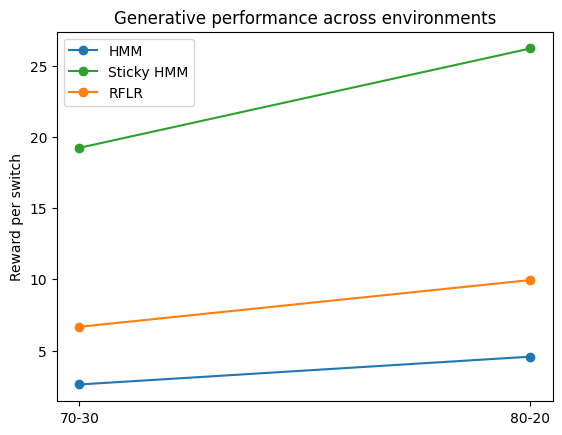

In [137]:
plot_df = summary.groupby(["model", "cond"], as_index=False)["reward_per_switch"].mean()

plt.figure()
for m in plot_df["model"].unique():
    s = plot_df[plot_df["model"] == m].copy()
    s["cond"] = pd.Categorical(s["cond"], categories=cond_order, ordered=True)
    s = s.sort_values("cond")
    plt.plot(s["cond"], s["reward_per_switch"], "o-", label=m, color=model_colors[m])

handles, labels = plt.gca().get_legend_handles_labels()
ordered = [labels.index(m) for m in model_order if m in labels]
plt.legend([handles[i] for i in ordered], [labels[i] for i in ordered])

plt.ylabel("Reward per switch")
plt.title("Generative performance across environments")
plt.savefig(
    os.path.join(OUTDIR, "reward_per_switch_plot.png"), dpi=300, bbox_inches="tight"
)
plt.show()

/var/folders/dd/930nbb3d6_qcp9hlz8cdvhg80000gn/T/ipykernel_20706/1639593283.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_s = s.groupby("cond", as_index=False)["switches"].mean().sort_values("cond")
/var/folders/dd/930nbb3d6_qcp9hlz8cdvhg80000gn/T/ipykernel_20706/1639593283.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_s = s.groupby("cond", as_index=False)["switches"].mean().sort_values("cond")
/var/folders/dd/930nbb3d6_qcp9hlz8cdvhg80000gn/T/ipykernel_20706/1639593283.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of p

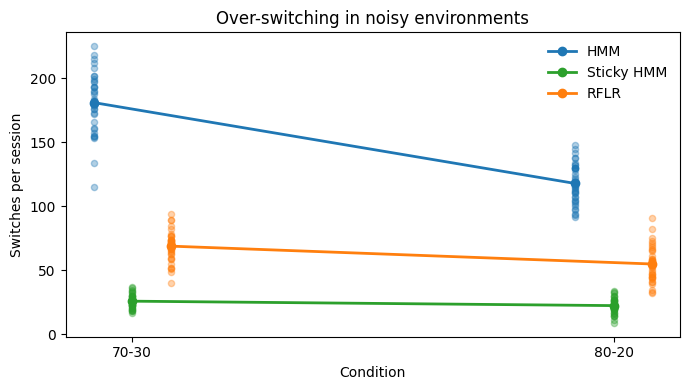

In [138]:
# Over-switching with multiple session points shown

# Clean + enforce condition order
df = summary.copy()
df["cond"] = pd.Categorical(
    df["cond"].astype(str).str.strip(), categories=cond_order, ordered=True
)

# x positions for categorical plotting
x_map = {c: i for i, c in enumerate(cond_order)}

plt.figure(figsize=(7, 4))

for i, m in enumerate(model_order):
    s = df[df["model"] == m].copy()
    if s.empty:
        continue

    # Slight horizontal dodge by model so points don't overlap
    offset = (i - (len(model_order) - 1) / 2) * 0.08

    # Session-level points (multiple switches)
    x = s["cond"].map(x_map).astype(float).to_numpy() + offset
    y = s["switches"].to_numpy()
    plt.scatter(x, y, s=20, alpha=0.35, color=model_colors[m])

    # Mean line across conditions
    mean_s = s.groupby("cond", as_index=False)["switches"].mean().sort_values("cond")
    xm = mean_s["cond"].map(x_map).astype(float).to_numpy() + offset
    ym = mean_s["switches"].to_numpy()
    plt.plot(xm, ym, "o-", color=model_colors[m], linewidth=2, label=m)

plt.xticks([x_map[c] for c in cond_order], cond_order)
plt.xlabel("Condition")
plt.ylabel("Switches per session")
plt.title("Over-switching in noisy environments")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(
    os.path.join(OUTDIR, "overswitching_plot.png"), dpi=300, bbox_inches="tight"
)
plt.show()